In [414]:
import os
import io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import simplejson as json
import missingno as msno
import ppscore as pps
import warnings
warnings.filterwarnings('ignore')

import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import kpss, adfuller

from scipy.stats import f_oneway, kruskal, rankdata
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from mlxtend.plotting import plot_pca_correlation_graph
plt.rcParams['figure.facecolor']='w'

In [415]:
# Importer le jeu de données nettoyé
data = pd.read_csv('data.csv')

In [416]:
data

,product_name,brands,nutrition_grade_fr,pnns1,nutriscore_fr,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,energy_kcal_100g
0,Banana Chips Sweetened (Whole),NaN,d,NaN,14.0,28.57,28.57,64.29,14.29,3.6,3.57,0.00000,536.089866
1,Peanuts,Torn & Glasser,b,NaN,0.0,17.86,0.00,60.71,17.86,7.1,17.86,0.63500,463.910134
2,Organic Salted Nut Mix,Grizzlies,d,NaN,12.0,57.14,5.36,17.86,3.57,7.1,17.86,1.22428,607.074570
3,Breadshop Honey Gone Nuts Granola,Unfi,NaN,NaN,NaN,18.27,1.92,63.46,11.54,7.7,13.46,1.42240,461.998088
4,Organic Muesli,Daddy's Muesli,c,NaN,7.0,18.75,4.69,57.81,15.62,9.4,14.06,0.13970,438.097514
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208489,Fiche Brevet,Hatier,b,NaN,0.0,1.00,1.00,11.00,1.00,10.0,10.00,10.00000,0.956023
208490,Natural Cassava,Industria De Casabe Paul,a,NaN,-1.0,0.00,0.00,87.06,2.35,4.7,1.18,0.03048,353.011472
208491,Tartines craquantes bio au sarrasin,Le Pain des fleurs,a,Cereals and potatoes,-4.0,2.80,0.60,74.80,2.60,5.9,13.00,0.68000,392.686424
208492,Amandes,Biosic,b,NaN,0.0,3.73,3.73,16.09,3.89,12.2,21.22,0.10000,575.047801


In [417]:
data.dtypes

product_name           object
brands                 object
nutrition_grade_fr     object
pnns1                  object
nutriscore_fr         float64
fat_100g              float64
saturated-fat_100g    float64
carbohydrates_100g    float64
sugars_100g           float64
fiber_100g            float64
proteins_100g         float64
salt_100g             float64
energy_kcal_100g      float64
dtype: object

**Affichons les principales informations sur le dataframe de données comme guide pour une exploration plus approfondie.**

In [418]:
def print_null_pct(data):
    tot_null = data.isna().sum().sum()
    print('nb of null: ', tot_null, '\npct of null: ',
        '{:.1f}'.format(tot_null*100/(data.shape[0]*data.shape[1])))
    
print(data.shape)
print_null_pct(data)    

(208494, 13)
nb of null:  164246 
pct of null:  6.1


In [419]:
# Vérification des colonnes dans data
for i, c in enumerate(data.columns):
    print('\n'+c if i % 6 == 0 else c, end=' | ')


product_name | brands | nutrition_grade_fr | pnns1 | nutriscore_fr | fat_100g | 
saturated-fat_100g | carbohydrates_100g | sugars_100g | fiber_100g | proteins_100g | salt_100g | 
energy_kcal_100g | 

In [420]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208494 entries, 0 to 208493
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   product_name        206144 non-null  object 
 1   brands              204401 non-null  object 
 2   nutrition_grade_fr  206529 non-null  object 
 3   pnns1               54621 non-null   object 
 4   nutriscore_fr       206529 non-null  float64
 5   fat_100g            208494 non-null  float64
 6   saturated-fat_100g  208494 non-null  float64
 7   carbohydrates_100g  208494 non-null  float64
 8   sugars_100g         208494 non-null  float64
 9   fiber_100g          208494 non-null  float64
 10  proteins_100g       208494 non-null  float64
 11  salt_100g           208494 non-null  float64
 12  energy_kcal_100g    208494 non-null  float64
dtypes: float64(9), object(4)
memory usage: 20.7+ MB


# 1 Analyse univariée

Traçons les histogrammes des données quantitatives, ainsi que la moyenne, la médiane et le mode.

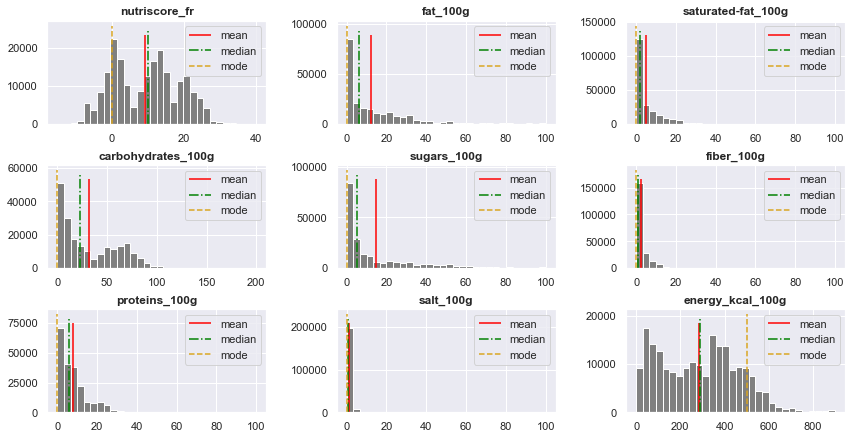

In [421]:
plot_enabled = True
# Plotting histograms of the main quantitative continuous columns

# -- reordering columns
quant_cols = ['nutriscore_fr', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
              'proteins_100g', 'salt_100g', 'energy_kcal_100g']


fig = plt.figure(figsize=(12,10))

# for i, ax, c in enumerate(zip(fig.ravel(), sorted(quant_cols))):
for i, c in enumerate(quant_cols,1):
    ax = fig.add_subplot(5,3,i)
    ax.hist(data[c],  bins=30, color='grey')
    ax.set_title(c)
    ax.vlines(data[c].mean(), *ax.get_ylim(),  color='red', ls='-', lw=1.5)
    ax.vlines(data[c].median(), *ax.get_ylim(), color='green', ls='-.', lw=1.5)
    ax.vlines(data[c].mode()[0], *ax.get_ylim(), color='goldenrod', ls='--', lw=1.5)
    ax.legend(['mean', 'median', 'mode'])
    ax.title.set_fontweight('bold')
    
# plt.tight_layout(w_pad=4.5, h_pad=-1)
plt.tight_layout(w_pad=2, h_pad=0.65)
# plt.gcf().set_size_inches(16,7)

if plot_enabled: plt.savefig(os.getcwd()+'A_1_1_histograms.png',
                             dpi=400);
plt.show()

Nous remarquons que:

Toute les distributions ont un pic autour de zéro. Cela ne peut pas etre interprété comme une accumulation de valeurs erronées, car certains produits ne contiennent vraiment aucune graisse, ni sucre, ni glucide.

La plupart des distributions sont asymétriques, sauf le nutriscore qui a une distribution bimodale

**Test de normalité Kolmogorov Smirnov:**

Les variables quantitatives sont-elles de distribution normale? (hypothèse à valider pour pouvoir appliquer le test ANOVA)

In [422]:
?stats.normaltest
data[numeric_columns].head()

,nutriscore_fr,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,energy_kcal_100g
0,14.0,28.57,28.57,64.29,14.29,3.6,3.57,0.00000,536.089866
1,0.0,17.86,0.00,60.71,17.86,7.1,17.86,0.63500,463.910134
2,12.0,57.14,5.36,17.86,3.57,7.1,17.86,1.22428,607.074570
3,NaN,18.27,1.92,63.46,11.54,7.7,13.46,1.42240,461.998088
4,7.0,18.75,4.69,57.81,15.62,9.4,14.06,0.13970,438.097514


In [424]:
from scipy import stats
numeric_columns = data.select_dtypes(include = ['int32','float64']).columns
numeric_columns = numeric_columns[1:]

for column in numeric_columns:
    print('________\n{}'.format(column))
    D, p = stats.kstest(data[column].dropna(), 
                     'norm', 
                     args=(data[column].mean(), data[column].std()))
    alpha = 5e-2
    print("p = {}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("L'hypothèse nulle peut être rejetée : {} n'est pas issu d'une distribution normale".format(column))
    else:
        print("L'hypothèse nulle ne peut pas être rejetée")

________
fat_100g
p = 0.0
L'hypothèse nulle peut être rejetée : fat_100g n'est pas issu d'une distribution normale
________
saturated-fat_100g
p = 0.0
L'hypothèse nulle peut être rejetée : saturated-fat_100g n'est pas issu d'une distribution normale
________
carbohydrates_100g
p = 0.0
L'hypothèse nulle peut être rejetée : carbohydrates_100g n'est pas issu d'une distribution normale
________
sugars_100g
p = 0.0
L'hypothèse nulle peut être rejetée : sugars_100g n'est pas issu d'une distribution normale
________
fiber_100g
p = 0.0
L'hypothèse nulle peut être rejetée : fiber_100g n'est pas issu d'une distribution normale
________
proteins_100g
p = 0.0
L'hypothèse nulle peut être rejetée : proteins_100g n'est pas issu d'une distribution normale
________
salt_100g
p = 0.0
L'hypothèse nulle peut être rejetée : salt_100g n'est pas issu d'une distribution normale
________
energy_kcal_100g
p = 0.0
L'hypothèse nulle peut être rejetée : energy_kcal_100g n'est pas issu d'une distribution normale


Le test de Kolmogorov Smirnov confirme la non normalité des distributions de données : on ne peut appliquer le test d'analyse de la variance ANOVA.

**Boxplots**

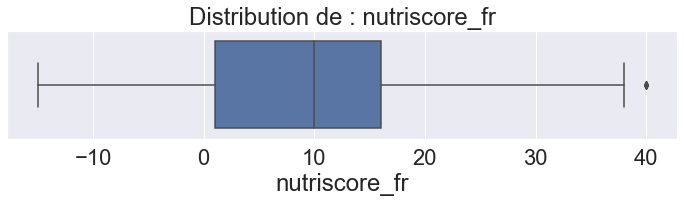

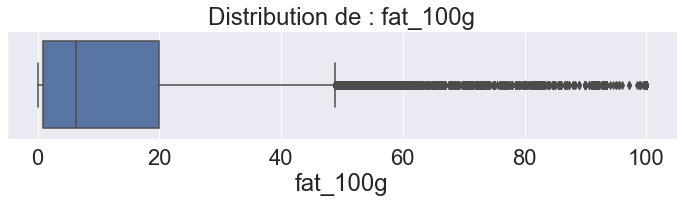

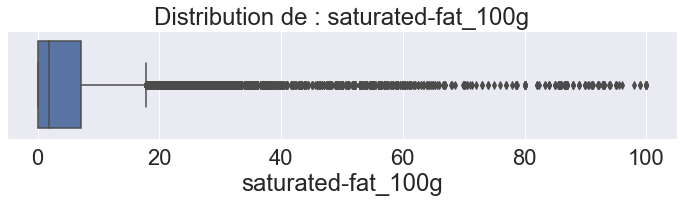

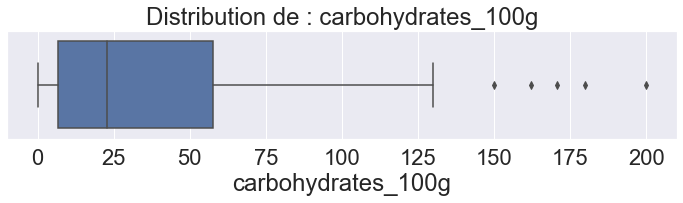

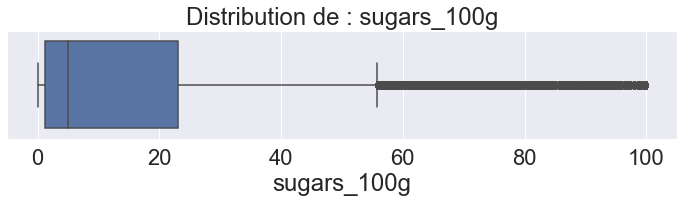

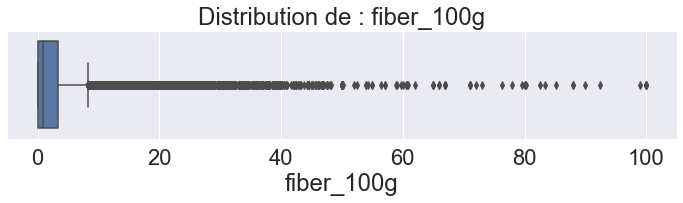

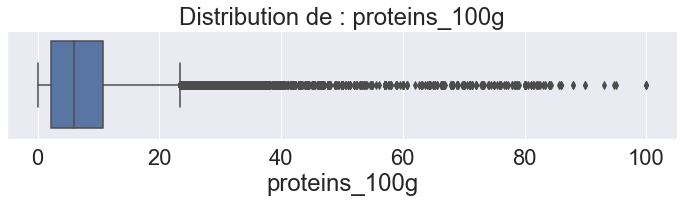

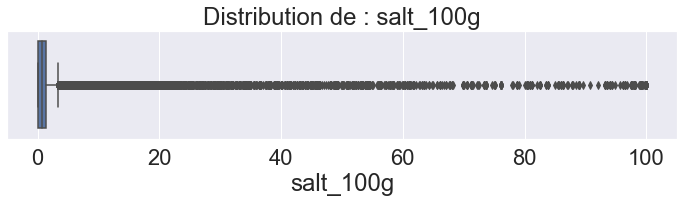

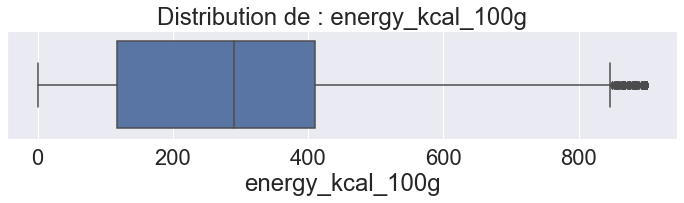

In [358]:
numeric_columns = data.select_dtypes(include = ['int32','float64']).columns
sns.set(font_scale=2)
for column in numeric_columns:
    plt.figure(figsize = (12,2))
    
    sns.boxplot(data[column])
    chaine = 'Distribution de : ' + column
    plt.title(chaine)
    plt.xlabel(column)
    plt.show()
sns.set(font_scale=1)

**Score nutritionnel:**La distribution est de type bi-modale avec un mode autour de 0 .

**Lipides:**La majorité des produits contiennent peu de lipides. La distribution est très excentrée vers la gauche. Mais il faut aussi regarder  les graisses saturées, critère essentiel à surveiller pour une alimentation saine.
Là aussi la distribution est très excentrée vers la gauche. 

Regardons les produits contenant le plus de graisses saturées.

In [359]:
data[data['energy_kcal_100g'] > 500].nlargest(5, 'saturated-fat_100g')

,product_name,brands,nutrition_grade_fr,pnns1,nutriscore_fr,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,energy_kcal_100g
109576,Coconut Oil,Desi,e,NaN,20.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,875.000000
109577,Coconut Oil,Desi,e,NaN,20.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,875.000000
123961,"St. Jamaica, Coconut Oil",St Jamaica Legend,e,NaN,20.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,900.000000
133807,Frites & Fritures,Vita d'Or,e,Fat and sauces,20.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,884.321224
137204,Jog'Frit,Jog'Frit,e,Fat and sauces,20.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,884.321224


Le produit le plus nocif en termes de taux de graisses saturées est l'huile de coco. A éviter dans une alimentation saine.

**Glucide:**La distribution est légèrement bi-modale. La majorité des produits contiennent peu de glucides. Dans le cadre d'une alimentation équilibrée, il faut surtout regarder les sucres.

**Sucre_100g:**On retrouve un peu la même distribution que celle des graisses saturées, la plupart des produits ont un taux de sucre relativement faible.

In [360]:
data[data['energy_kcal_100g'] > 450].nlargest(5, 'sugars_100g')

,product_name,brands,nutrition_grade_fr,pnns1,nutriscore_fr,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,energy_kcal_100g
6894,Holiday Happiness Mix,"Over The Top, Kingston Marketing Co",d,NaN,16.0,0.0,0.0,100.0,100.0,0.0,7.014723,1.4224,500.0
6895,Princess Mix Decorations,Over The Top,d,NaN,16.0,0.0,0.0,100.0,100.0,0.0,7.014723,1.4224,500.0
6896,Frosted Mix,"Over The Top, Kingston Marketing Co",d,NaN,16.0,0.0,0.0,100.0,100.0,0.0,7.014723,1.4224,500.0
45923,"Sweet N Fun, Egg Cup Gumball Dispenser",Walgreens Co.,d,NaN,16.0,0.0,0.0,100.0,100.0,0.0,0.000000,0.0000,500.0
46909,Gum Balls,Gold Emblem,d,NaN,16.0,0.0,0.0,100.0,100.0,0.0,0.000000,0.0000,500.0


**Fibre:**Distribution excentrée vers la gauche et concentrée entre 0 et 5g.

**Protéines:**Encore une fois, une distribution très excentrée vers la gauche et la plupart des produits contiennent moins de 30% de protéines.

**Sel:**La plupart des aliments ont une teneur en sel inférieure à 2g. La distribution est aussi excentrée vers la gauche.

In [361]:
data.nlargest(5, 'salt_100g')

,product_name,brands,nutrition_grade_fr,pnns1,nutriscore_fr,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,energy_kcal_100g
145251,Véritable sel de mer la baleine,La baleine,c,NaN,10.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
148238,Sel de Guérande,Reflets de France,c,unknown,10.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
150587,Sel fin de Guerande,Itineraires des saveurs,c,unknown,10.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
155395,Sel fin iodé - sel de mer,Leader Price,c,unknown,10.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
155396,Fleur de sel de Guérande,Franprix,c,unknown,10.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0


Les produits les plus salés sont les sels

**Energie:**On observe une distribution plutôt de type pluri-modale (des pics autour de 60, 250 ou 370 calories) et excentrée vers la gauche avec la plupart des produits en dessous de 550kcal.

In [362]:
data.nlargest(5, 'energy_kcal_100g')

,product_name,brands,nutrition_grade_fr,pnns1,nutriscore_fr,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,energy_kcal_100g
4220,Vegetable Shortening,Roundy's,e,NaN,20.0,100.0,23.08,0.0,0.0,0.0,0.0,0.0,900.0
4817,Premium Sesame Oil (100% Pure),"Dynasty, Jfc International Inc.",e,NaN,20.0,100.0,14.29,0.0,0.0,0.0,0.0,0.0,900.0
4818,Sesame Oil,Dynasty,e,NaN,20.0,100.0,14.29,0.0,0.0,0.0,0.0,0.0,900.0
4899,"Premium Sesame Oil, Hot","Dynasty, Jfc International Inc.",e,NaN,20.0,100.0,14.29,0.0,0.0,0.0,0.0,0.0,900.0
5115,Refined Coconut Oil,"Shurfine, Topco Associates Inc.",e,NaN,20.0,100.0,85.71,0.0,0.0,0.0,0.0,0.0,900.0


Les produits les plus caloriques sont les huiles et les beurres composés principalement de lipides (nutriments les plus denses).

In [363]:
data[data['energy_kcal_100g'] > 0].nsmallest(5, 'energy_kcal_100g')

,product_name,brands,nutrition_grade_fr,pnns1,nutriscore_fr,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,energy_kcal_100g
167335,Free,7UP,b,Beverages,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.143403
184294,Coca-Cola light,Coca-Cola,b,Beverages,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.191205
184297,Coca-Cola light koffeinfrei,Coca-Cola,b,Beverages,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.191205
189736,Coca-Cola light,Coca-Cola,b,Beverages,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.191205
189737,Coca-Cola light koffeinfrei,Coca-Cola,b,Beverages,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.191205


# Variable qualitative:

**Barplots**

**La répartition des notes (entre A et E) du nutrition_grade_fr**

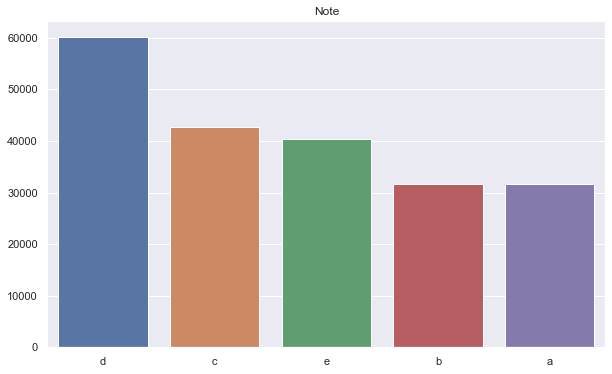

In [364]:
plt.figure(figsize=(10,6))
plt.title('Note')
sns.barplot(x = data.nutrition_grade_fr.value_counts().index,
           y = data.nutrition_grade_fr.value_counts().values )
plt.show()

**Quelle est la répartition des notes (entre A et E) des produits en pourcentage?**

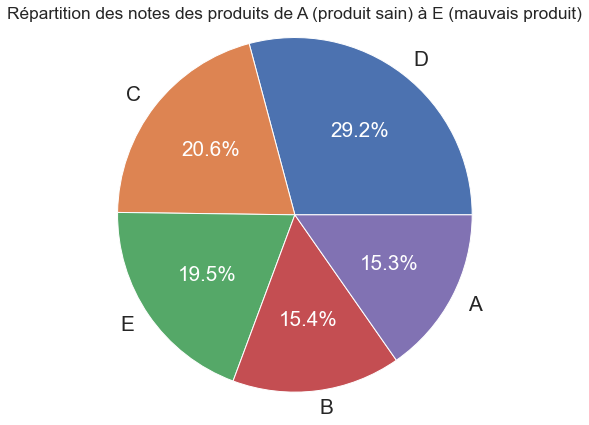

In [365]:
grades = data['nutrition_grade_fr'].value_counts()

fig, ax = plt.subplots(figsize=(7, 7))

patches, texts, autotexts = ax.pie(grades.values, labels=grades.index, autopct='%1.1f%%')
for t in texts:
    t.set_text(t.get_text().upper())
    t.set_size('xx-large')
for t in autotexts: 
    t.set_size('xx-large')
    t.set_color('w')
ax.set_title('Répartition des notes des produits de A (produit sain) à E (mauvais produit)', size='x-large')
ax.axis('equal')

plt.show()


La répartition est homogène entre les différentes notes.

**pnns1**

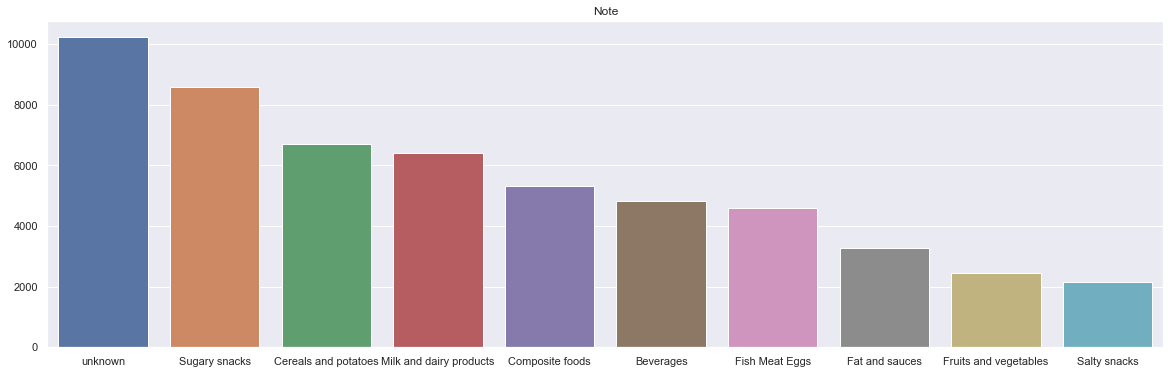

In [366]:
plt.figure(figsize=(20,6))
plt.title('Note')
sns.barplot(x = data.pnns1.value_counts().index,
           y = data.pnns1.value_counts().values )
plt.show()

In [367]:
cat_unknown = len(data[data['pnns1'] == 'unknown'])
cat_null = len(data[data['pnns1'].isnull()])
print(f"{(cat_unknown + cat_null) / data.shape[0] * 100:.0f}% des produits sont sans catégories.")

79% des produits sont sans catégories.


**brands**

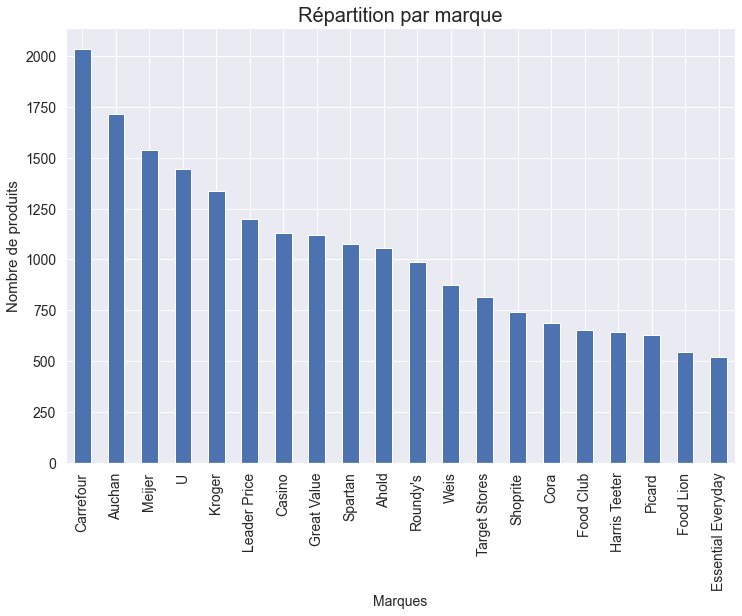

In [368]:
fig, ax = plt.subplots(figsize=(12, 8)
                      )
data['brands'].value_counts().head(20).plot(kind='bar')
ax.set_title("Répartition par marque", size=20)
ax.tick_params(labelsize=14)
ax.set_xlabel("Marques", size=14)
ax.set_ylabel('Nombre de produits', size=15)

plt.show()

Les marques les plus représentées sont Carrfour et Auchan

In [369]:
#description des grandeurs
data[['energy_kcal_100g',
      'fat_100g',
      'saturated-fat_100g',
      'carbohydrates_100g',
      'sugars_100g',
       'fiber_100g',
      'proteins_100g',
      'salt_100g',
      'nutriscore_fr']
    ].describe()

,energy_kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutriscore_fr
count,208494.000000,208494.000000,208494.000000,208494.000000,208494.000000,208494.000000,208494.000000,208494.000000,206529.000000
mean,284.927391,12.417522,4.948263,32.344001,14.885961,2.343044,7.779883,1.257223,9.353519
std,178.560019,15.508029,7.492724,28.103355,19.751271,4.085262,7.862260,3.929896,8.990296
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,117.112811,0.800000,0.000000,6.670000,1.200000,0.000000,2.270000,0.111760,1.000000
50%,289.913958,6.300000,1.790000,22.860000,5.000000,0.800000,6.000000,0.708660,10.000000
75%,409.894837,20.000000,7.140000,57.500000,23.000000,3.300000,10.710000,1.422400,16.000000
max,900.000000,100.000000,100.000000,200.000000,100.000000,100.000000,100.000000,100.000000,40.000000


#  Analyse bivariée 

# Influence des variables nutritives sur l'énergie.

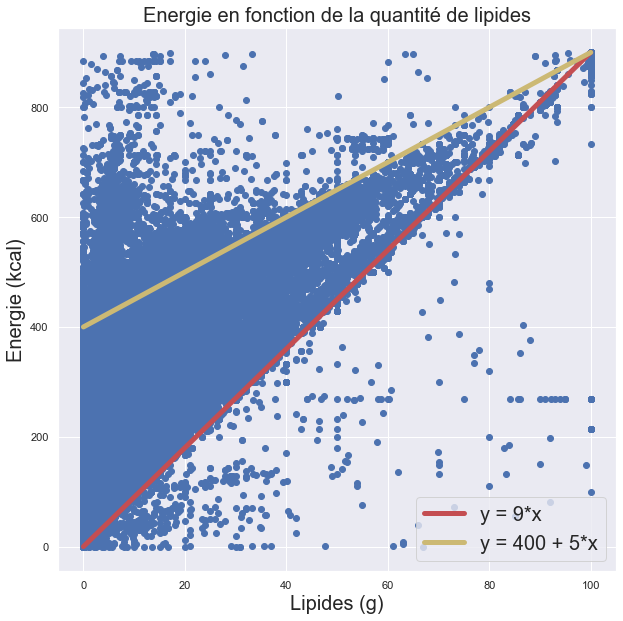

In [370]:
fig, ax = plt.subplots(figsize=(10, 10))

x = np.linspace(0, 100)
y1 = 9*x
y2 = 400 + 5*x

ax.scatter(data['fat_100g'], data['energy_kcal_100g'])
ax.plot(x, y1, color='r', linewidth=5, label="y = 9*x")
ax.plot(x, y2, color='y', linewidth=5, label="y = 400 + 5*x")
ax.set(xlabel='Lipides (g)', ylabel='Energie (kcal)', 
       title="Energie en fonction de la quantité de lipides")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)
ax.legend(loc="lower right", prop={'size':20})

plt.show()

On observe que l'apport énergétique est très dépendant du taux de lipides, c'est pourquoi on a un coefficient de corrélation assez élevé entre les 2 variables. Cela s'explique par le fait que les lipides sont les nutriments les plus denses (9 kcal/g contre 4 pour les glucides par exemple), donc ils déterminent en grande partie l'apport énergétique. L'apport énergétique est d'ailleurs compris entre des produits composés de lipides uniquement (droite du bas) et les produits composés de lipides et de glucides ou protéines (droite du haut).

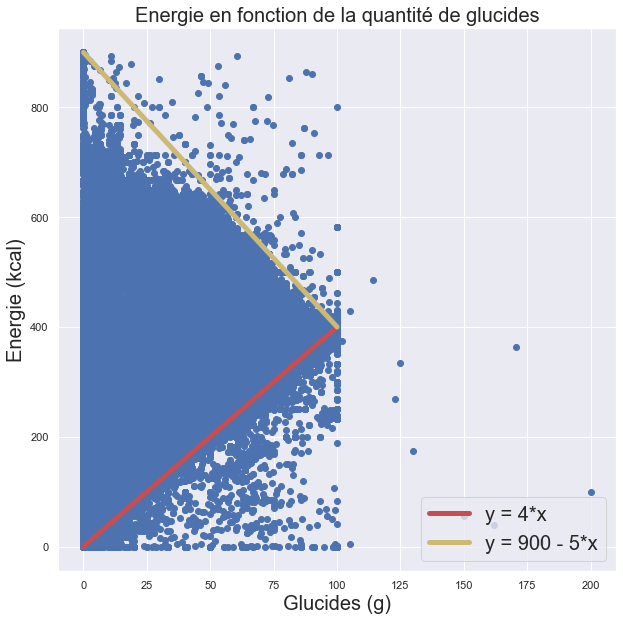

In [371]:
fig, ax = plt.subplots(figsize=(10, 10))

x = np.linspace(0, 100)
y1 = 4*x
y2 = 900 - 5*x

ax.scatter(data['carbohydrates_100g'], data['energy_kcal_100g'])
ax.plot(x, y1, color='r', linewidth=5, label="y = 4*x")
ax.plot(x, y2, color='y', linewidth=5, label="y = 900 - 5*x")
ax.set(xlabel='Glucides (g)', ylabel='Energie (kcal)', 
       title="Energie en fonction de la quantité de glucides")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)
ax.legend(loc="lower right", prop={'size':20})


plt.show()

Les glucides sont la seconde source d'apport énergétique. On voit bien que la valeur énergétique est bornée d'une part par les produits qui ne contiennent que des glucides (droite du bas) et les produits composés de lipides et de glucides (droite du haut), dont la valeur énergétique diminue lorsque le taux de glucide augmente.

# Analyse bivariée entre variables nutritives et sous variables nutritives

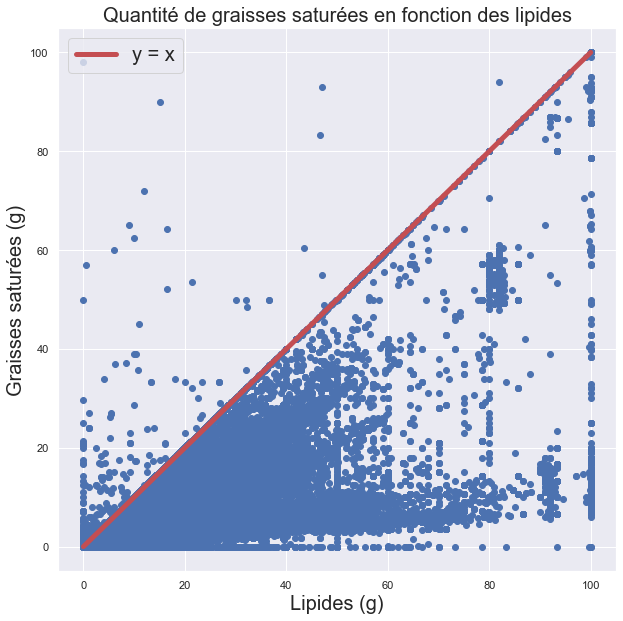

In [372]:
fig, ax = plt.subplots(figsize=(10, 10))

x = np.linspace(0, 100)
y1 = x
y2 = 100 - 7.1*x

ax.scatter(data['fat_100g'], data['saturated-fat_100g'])
ax.plot(x, y1, color='r', linewidth=5, label='y = x')
#ax.plot(x, y2, color='r', linewidth=5)
ax.set(xlabel='Lipides (g)', ylabel='Graisses saturées (g)', 
       title="Quantité de graisses saturées en fonction des lipides")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)
ax.legend(loc="upper left", prop={'size':20})


plt.show()

On vérifie bien que le taux de graisses saturées est souvent inférieur au taux de lipides. Le coefficient de corrélation plutôt élevé s'explique par le fait que les graisses saturées sont des lipides. L'inverse par contre n'est pas vraie, et l'on peut avoir des produits avec beaucoup de lipides et peu de graisses saturées (par exemple l'huile d'olive).

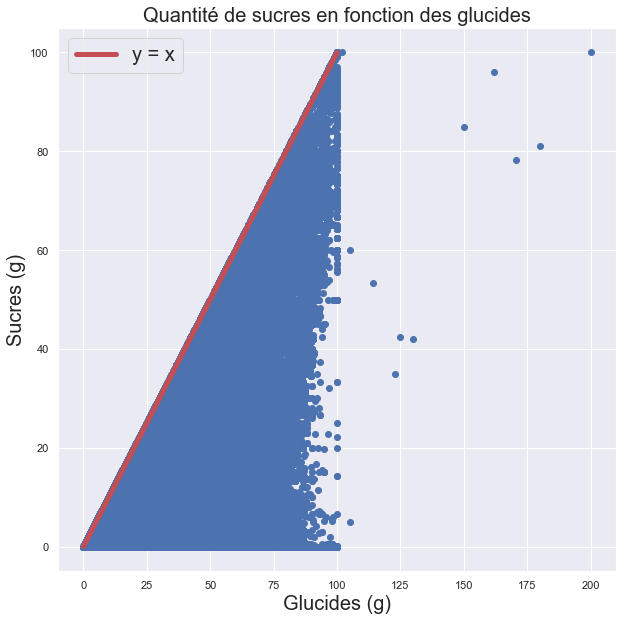

In [373]:
fig, ax = plt.subplots(figsize=(10, 10))

x = np.linspace(0, 100)
y1 = x
y2 = 100 - 7.1*x

ax.scatter(data['carbohydrates_100g'], data['sugars_100g'])
ax.plot(x, y1, color='r', linewidth=5, label="y = x")
#ax.plot(x, y2, color='r', linewidth=5)
ax.set(xlabel='Glucides (g)', ylabel='Sucres (g)', 
       title="Quantité de sucres en fonction des glucides")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)
ax.legend(loc="upper left", prop={'size':20})


plt.show()

Comme pour les lipides et les graisses saturées, les sucres sont un type de glucides, ce qui explique le coefficient de corrélation un peu élevé.

# Influence des variables nutritives sur le score nutrigrade.

Nous aimerions savoir quels composants nutritionnels ont le plus d'influence sur le nutrigrade d'un produit. Traçons des boîtes à moustaches pour chaque variable quantitative pour chaque nutrigrade.

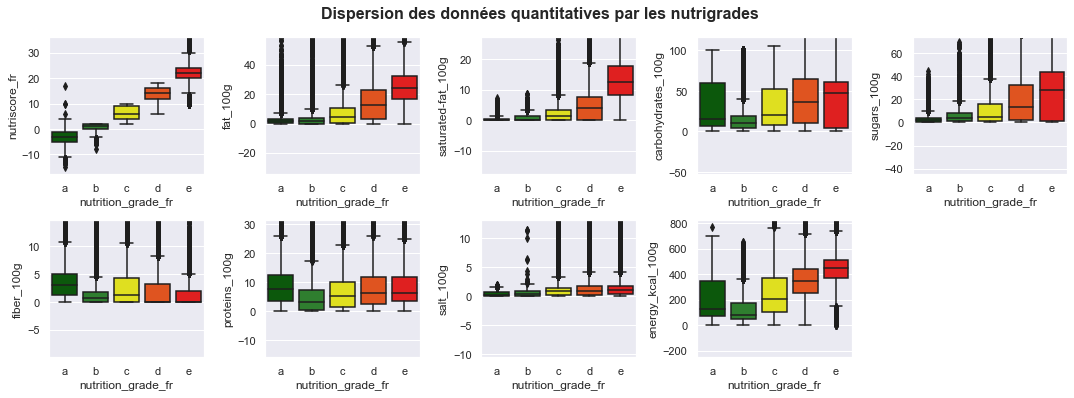

In [374]:
# Plotting boxplot of quantitative features for each nutrigrade

nutri_pal = ['darkgreen', 'forestgreen', 'yellow', 'orangered', 'red']

fig = plt.figure(figsize=(15,8))
with sns.color_palette(nutri_pal):
    for i, c in enumerate(quant_cols,1):
        ax = fig.add_subplot(3,5,i)
        sns.boxplot(data=data, x='nutrition_grade_fr', y=c, order=list('abcde'), ax=ax)
        min = data[c].mean()-3*data[c].std()
        max = data[c].mean()+3*data[c].std()
        plt.ylim(min,max)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Dispersion des données quantitatives par les nutrigrades', fontsize=16,
             fontweight='bold')
if plot_enabled: plt.savefig(os.getcwd()+'A_3_1_boxplots.png',
                             dpi=400);
plt.show()

Les distributions sont très différentes par rapport au nutrigrade. À l'exception du nutriscore qui est à la base du classement nutrigrade, nous remarquons que les graisses, les graisses saturées et l'énergie (et donc l'énergie provenant des graisses) présentent les distributions les plus différentes le long du nutrigrade.

Dans une moindre mesure, le sucre, les glucides, le sel et les fibres présentent également des distributions différentes.



**Inffluence du nutriscore sur le nutriscore gade**

In [425]:
def modal_boxplots(dataframe, modal_feature, numerical_feature):
    '''This function return a plot of boxplots for each modality.
    Useful for bivariate analysis.'''
    
    # Creating a copy of the two features
    data_sample = dataframe[[modal_feature, numerical_feature]].copy()

    # Drop the rows where values are missing for the two features
    data_sample = data_sample.dropna(subset=[modal_feature, numerical_feature])

    # Getting the list of modalities
    modalities = data_sample[modal_feature].sort_values().unique()
    groups = []

    # Iteration on each modality
    for modality in modalities:
        # Keep only the numerical_feature for the rows (kind of a groupby)
        groups.append(data_sample[data_sample[modal_feature]==modality][numerical_feature])

    # Graphical properties   
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
                'markerfacecolor':'firebrick'}

    # Properties of the box-plot
    fig = plt.figure(figsize=(15, 6))
    plt.title(modal_feature + " vs " + numerical_feature, fontsize=20)
    plt.xlabel("Values of " + modal_feature, fontsize=15)
    plt.ylabel("Values of " + numerical_feature, fontsize=15)

    # Plotting the box-plot
    plt.boxplot(groups, labels=modalities, showfliers=False, medianprops=medianprops, 
                vert=True, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.show()

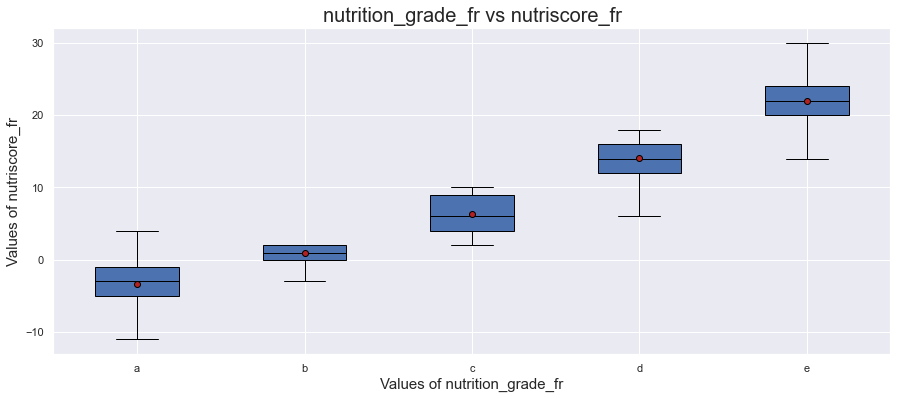

In [426]:
dataframe = data
modal_feature = 'nutrition_grade_fr'
numerical_feature = 'nutriscore_fr'

modal_boxplots(dataframe, modal_feature, numerical_feature)

Nous constatons que le taux de remplissage de 'nutrition_grade_fr' est exactement le même que celui de 'nutrition-score-fr_100g'. Nous supposons que la variable catégorielle 'nutrition_grade_fr' correspond à un encodage de la variable quantitative 'nutrition-score-fr_100g'.
Théoriquement, les diagrammes en boîtes devraient être disjoints.

# Analyse des catégories

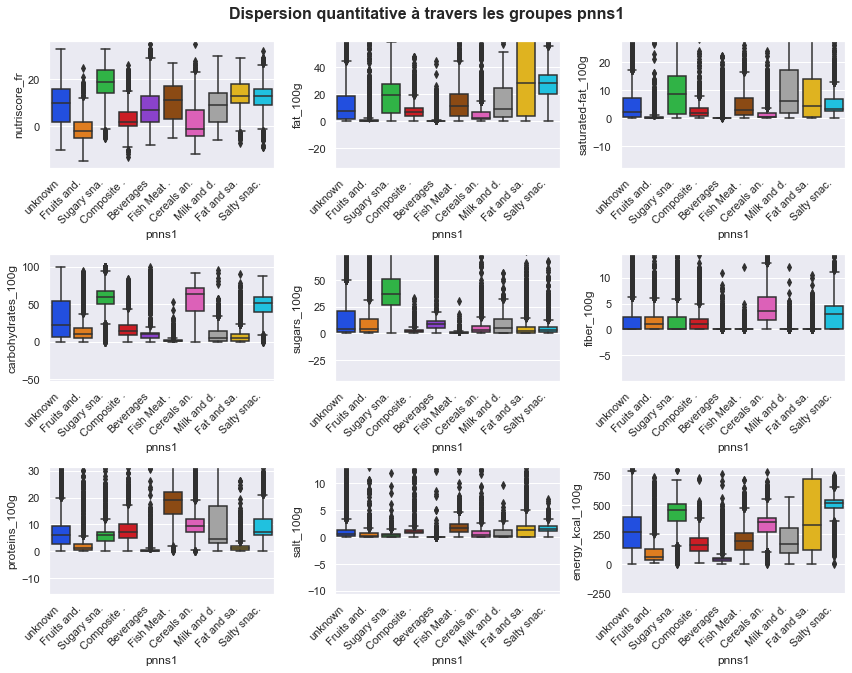

In [380]:
# Tracer des boîtes à moustaches de chaque donnée quantitative pour chaque catégorie pnns1

pnns1_pal = sns.color_palette(palette='bright')

fig = plt.figure(figsize=(12,15))
with sns.color_palette(pnns1_pal):
    for i, c in enumerate(quant_cols,1):
        ax = fig.add_subplot(5,3,i)
        sns.boxplot(data=data, x='pnns1', y=c, ax=ax)# order=list('abcde')
        min = data[c].mean()-3*data[c].std()
        max = data[c].mean()+3*data[c].std()
        plt.ylim(min,max)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        short_labels = [s[0:10]+'.' if len(s)>10 else s for s in labels]
        ax.axes.set_xticklabels(short_labels)
        plt.xticks(rotation=45, ha='right')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.suptitle('Dispersion quantitative à travers les groupes pnns1', fontsize=16,
             fontweight='bold')
if plot_enabled: plt.savefig(os.getcwd()+'A_3_1_pnns1_boxplots.png',
                             dpi=400);
plt.show()

Selon ces boîtes à moustaches, nous pouvons émettre l'hypothèse que les catégories pnns1 ne sont homogènes par aucune valeur quantitative.

**Traçons les valeurs du 'nutriscore' pour chaque catégorie 'pnns1'.**

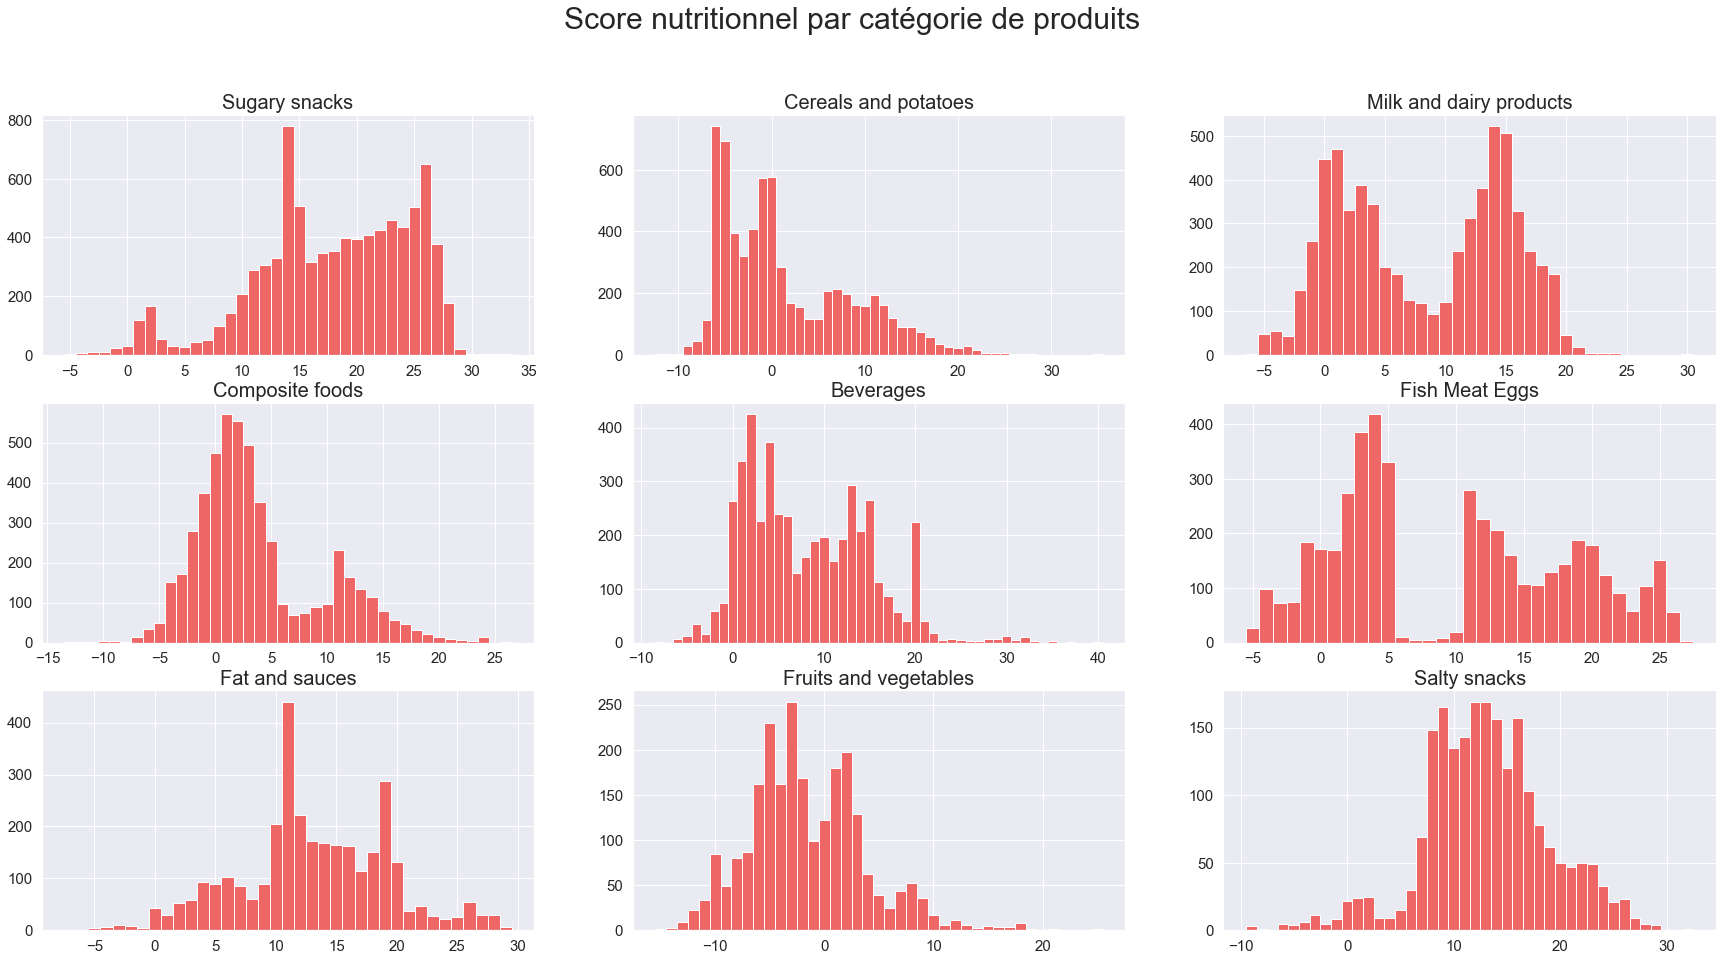

In [382]:
fig, axes = plt.subplots(3, 3, figsize=(30, 15))
fig.suptitle('Score nutritionnel par catégorie de produits', size=30)
idx = 0
for col in data['pnns1'].value_counts().index:
    if col != 'unknown':
        df_temp = data[data['pnns1'] == col]
        axes[idx // 3, idx % 3].bar(x=df_temp['nutriscore_fr'].value_counts().index, 
                                    height=df_temp['nutriscore_fr'].value_counts(), 
                                    color="#EE6666", edgecolor='white', width=1)   
        axes[idx // 3, idx % 3].set_title(f"{col}", size=20)
        axes[idx // 3, idx % 3].tick_params(labelsize=15)
        
        idx += 1

**Traçons les valeurs du 'nutriscore' pour chaque catégorie 'pnns1'.**

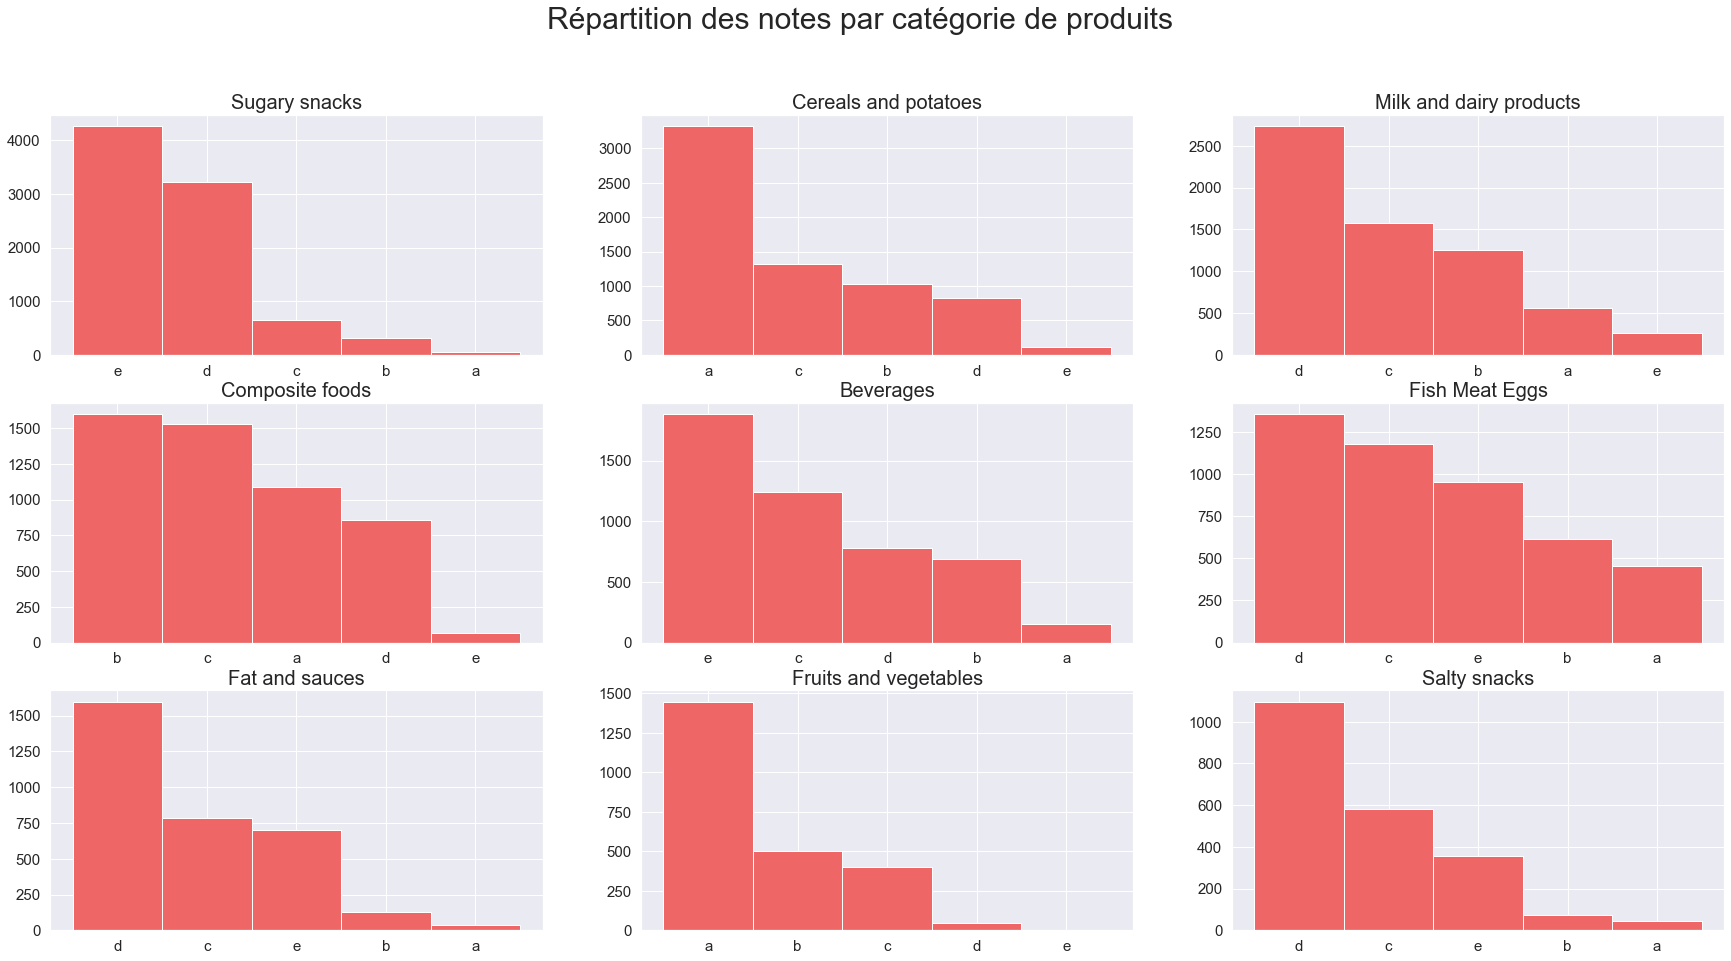

In [383]:
fig, axes = plt.subplots(3, 3, figsize=(30, 15))
fig.suptitle('Répartition des notes par catégorie de produits', size=30)
idx = 0
for col in data['pnns1'].value_counts().index:
    if col != 'unknown':
        df_temp = data[data['pnns1'] == col]
        axes[idx // 3, idx % 3].bar(x=df_temp['nutrition_grade_fr'].value_counts().index, 
                                    height=df_temp['nutrition_grade_fr'].value_counts(), 
                                    color="#EE6666", edgecolor='white', width=1)   
        axes[idx // 3, idx % 3].set_title(f"{col}", size=20)
        axes[idx // 3, idx % 3].tick_params(labelsize=15)
        
        idx += 1

# Analyse des marques

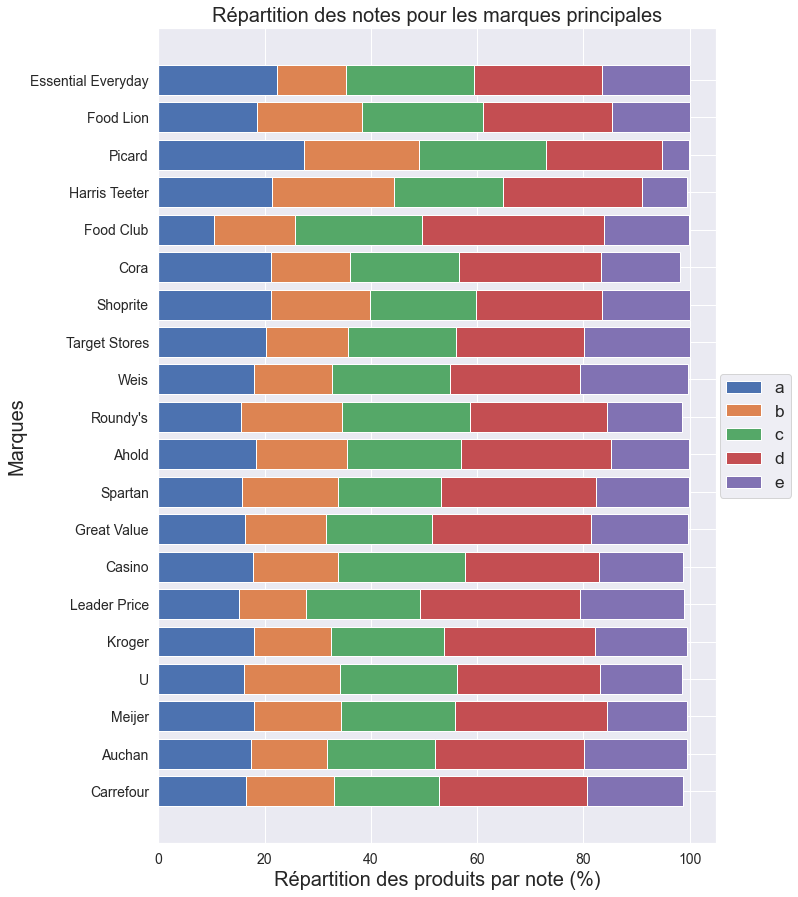

In [384]:
fig, ax = plt.subplots(figsize=(10, 15))
ax.set_title("Répartition des notes pour les marques principales", size=20)

data2 = data[data.brands.isin(data['brands'].value_counts().index)]
brands = pd.DataFrame(data2['brands'].value_counts())

for grade in ['a', 'b', 'c', 'd', 'e']:
    brands[grade] = data2[data2['nutrition_grade_fr'] == grade]['brands'].value_counts() / brands['brands'] * 100
    brands[f"cum_{grade}"] = data2[data2['nutrition_grade_fr'] <= grade]['brands'].value_counts() / brands['brands'] * 100

brands.sort_values('brands', inplace=True, ascending=False)
df_temp2 = brands[:20]

for grade in ['a', 'b', 'c', 'd', 'e']:
    ax.barh(y=df_temp2.index, width=df_temp2[grade], left=(df_temp2[f"cum_{grade}"]-df_temp2[grade]), label=grade)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.set(ylabel='Marques', xlabel='Répartition des produits par note (%)')
    ax.tick_params(labelsize=14)
    
    ax.legend(loc='right', bbox_to_anchor=(1.15, 0.5), fontsize='x-large')

plt.show()


**Corrélation entre variables nutritives**

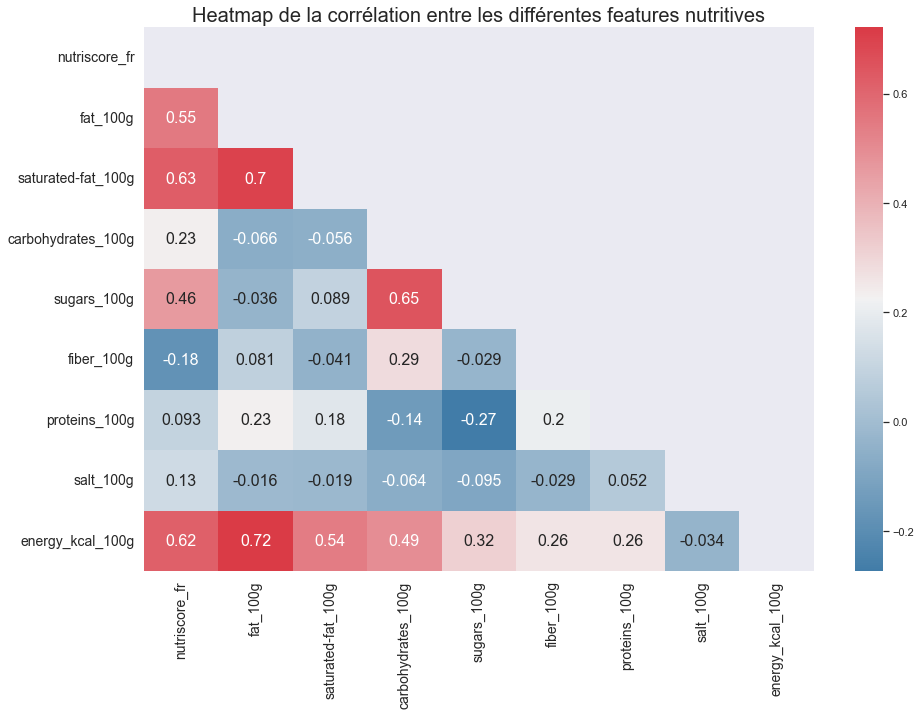

In [385]:
corr = data.corr()

# To mask upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
ax = sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, annot_kws={"size": 16})
ax.set_title("Heatmap de la corrélation entre les différentes features nutritives", size=20)
ax.tick_params(labelsize=14)
plt.show()

energy_100g : forte corrélation avec:

fat_100g
saturated-fat_100g
carbohydrates_100g
nutrition-score-fr_100g

fat_100g et saturated-fat_100g fortement corrélés

nutrition-score-fr_100g : forte corrélation avec:

saturated_fat_100g
energy_100g
fat_100g

sugars_100g : forte correlation avec carbohydrates_100g

sodium_100g correlation très forte avec salt_100g

# Analyse multivariée

**ACP(Analyse en Composantes Principales)**

Pour simplifier les données tout en conservant le plus d'information possible.Nous réalisons une analyse multivarié grâce à une ACP sur les variables quantitatives a fin de visualiser les relations entre  elles et construire de nouvelles variables pertinentes à partir de variables existantes.

**Nous standardiserons les données et procéderons à l'ACP avec les 9 variables quantitatives. Nous choisissons 8 composants principaux.**

In [ ]:
#### Analyse des composants principaux #####

np.set_printoptions(formatter={'float': '{: 6.2f}'.format})
## --Sélection des varaibles et d'index pour PCA
pca_cols = ['nutriscore_fr', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
              'proteins_100g', 'salt_100g', 'energy_kcal_100g'] 
pca_cols = [c for c in pca_cols if c!='nutriscore_fr']
df_sample = data.loc[:, pca_cols]
id_code = df_sample.index
X = df_sample.values
# --Normalisation des données
X_sc = StandardScaler().fit_transform(X)
# -- Détermination des composants principaux
n_comp = 8
pca = PCA(n_components=n_comp).fit(X_sc)
# -- Coefficients des composantes principales (selon les caractéristiques d'origine)
pca_df = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(n_comp)],
                      columns=pca_cols).T
# Projection de X sur les composantes principales
X_proj = pca.transform(X_sc)

**Essayons de comprendre les relations entre les variables et les composantes principales**

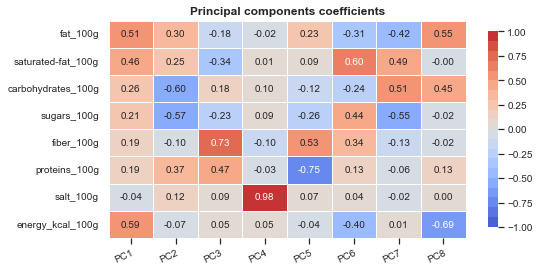

In [387]:
def plot_heatmap(corr, title, figsize=(8,4), vmin=-1, vmax=1, center=0,
                 palette = sns.color_palette("coolwarm", 20), shape='rect',
                 fmt='.2f', robust=False):
    
    fig, ax = plt.subplots(figsize=figsize)
    if shape == 'rect':
        mask=None
    elif shape == 'tri':
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    else:
        print('ERROR : this type of heatmap does not exist')

    palette = palette
    ax = sns.heatmap(corr, mask=mask, cmap=palette, vmin=vmin, vmax=vmax,
                     center=center, annot=True, annot_kws={"size": 10},fmt=fmt,
                     square=False, linewidths=.5, linecolor = 'white',
                     cbar_kws={"shrink": .9, 'label': None}, robust = robust,
                     xticklabels= corr.columns, yticklabels = corr.index)
    ax.tick_params(labelsize=10,top=False, bottom=True,
                labeltop=False, labelbottom=True)
    ax.collections[0].colorbar.ax.tick_params(labelsize=10)
    plt.setp(ax.get_xticklabels(), rotation=25, ha="right",rotation_mode="anchor")
    ax.set_title(title, fontweight='bold', fontsize=12)
    # return mask
# Tracé des coefficients des composantes principales
plot_heatmap(pca_df,'Principal components coefficients', vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("coolwarm", 20),figsize=(8,4),shape='rect')
if plot_enabled: plt.savefig(os.getcwd()+'A_4_1_principal_components.png',
                             dpi=400);
plt.show()

Le heatmap montre les corrélations entre les différentes variables et les composantes principales.les couleurs plus chaudes indiquent des corrélations positives fortes et les couleurs plus froides des corrélations négatives fortes. Les coefficients plus élevés indiquent une contribution plus importante de la variable à la composante principale.

**déterminer le nombre de composantes principales à retenir dans cette analyse ACP**

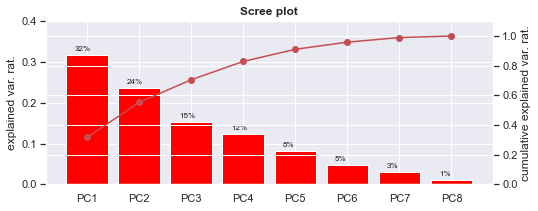

In [388]:
# Tracé du rapport de variance expliquée dans un graphe d'éboulis

exp_var_rat = pca.explained_variance_ratio_
plt.bar(x=pca_df.columns, height=exp_var_rat, color='red')
ax1 = plt.gca()
ax1.set(ylim=(0,0.4))
ax2 = ax1.twinx()
ax2.plot(exp_var_rat.cumsum(), 'ro-')
ax2.set(ylim=(0,1.1))
ax1.set_ylabel('explained var. rat.')
ax2.set_ylabel('cumulative explained var. rat.')

for i, p in enumerate(ax1.patches):
    ax1.text( p.get_width()/5 + p.get_x(), p.get_height()+ p.get_y()+0.01,
             '{:.0f}%'.format(exp_var_rat[i]*100),
                fontsize=8, color='k')
    
plt.gcf().set_size_inches(8,3)
plt.title('Scree plot', fontweight='bold')
if plot_enabled: plt.savefig(os.getcwd()+'A_4_1_scree_plot.png',
                             dpi=400);
plt.show()
     

Il est nécessaire de retenir 4 composantes principales pour explorer les données de manière plus approfondie.
la première composante principale est fortement corrélée avec les variables les plus importantes.
les composantes principales suivantes capturent de moins en moins de variabilité.
avec un PC1 = 32%, PC2 = 24%, PC3 = 15% et PC4 = 12%, nous conservons les quatre composantes principales pour capturer suffisamment de variabilité, étant donné que la somme de ces pourcentages s'élève à 83%.

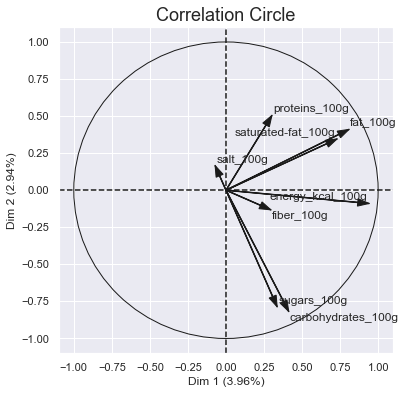

In [389]:
# En utilisant le pca ci-dessus calculé (PC1, PC2)

figure, correlation_matrix = \
     plot_pca_correlation_graph(X = X_sc,
                                variables_names = pca_cols,
                                dimensions = (1, 2),
                                figure_axis_size = 6,
                                X_pca = X_proj[:,0:2],
                                explained_variance = pca.explained_variance_ratio_[0:2])

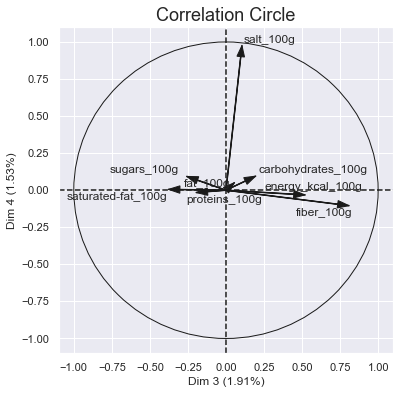

In [390]:
# Using the pca above computed (PC3, PC4)

figure, correlation_matrix = \
     plot_pca_correlation_graph(X = X_sc,
                                variables_names = pca_cols,
                                dimensions=(3, 4),
                                figure_axis_size=6,
                                X_pca = X_proj[:,0:4],
                                explained_variance = pca.explained_variance_ratio_[0:4])
     

In [391]:
correlation_matrix

,Dim 1,Dim 2,Dim 3,Dim 4
fat_100g,0.808584,0.410276,-0.195740,-0.015664
saturated-fat_100g,0.730180,0.346087,-0.377661,0.005708
carbohydrates_100g,0.412350,-0.818067,0.195008,0.095105
sugars_100g,0.336249,-0.786222,-0.257794,0.093174
fiber_100g,0.295231,-0.132469,0.808474,-0.104171
proteins_100g,0.301904,0.504541,0.520162,-0.031713
salt_100g,-0.071384,0.166306,0.105007,0.975713
energy_kcal_100g,0.940513,-0.089413,0.055368,0.050962


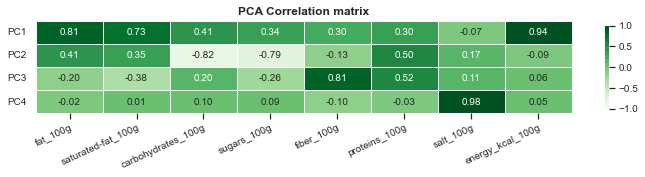

In [392]:
# Tracer la matrice de corrélation PCA

plot_heatmap(correlation_matrix.T,'PCA Correlation matrix', vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("Greens", 20),figsize=(12,1.7),shape='rect')
plt.gca().set_yticklabels(['PC1', 'PC2', 'PC3', 'PC4'])
if plot_enabled: plt.savefig(os.getcwd()+'A_4_1_correaltion_matrix.png',
                             dpi=400);
plt.show()

**Projection:**

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

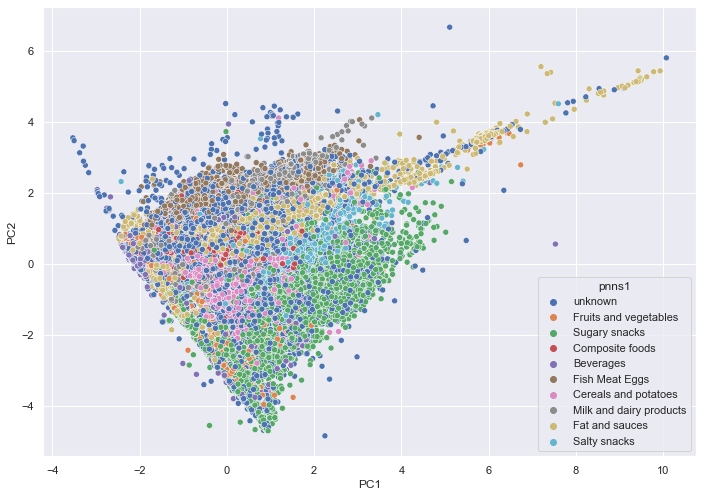

In [404]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
df_sample['PC1']=[ x[0] for x in X_proj]
df_sample['PC2']=[ x[1] for x in X_proj]
df_sample['pnns1']=data['pnns1']
sns.scatterplot(data=df_sample, x='PC1', y='PC2', hue='pnns1')

<AxesSubplot:xlabel='PC3', ylabel='PC4'>

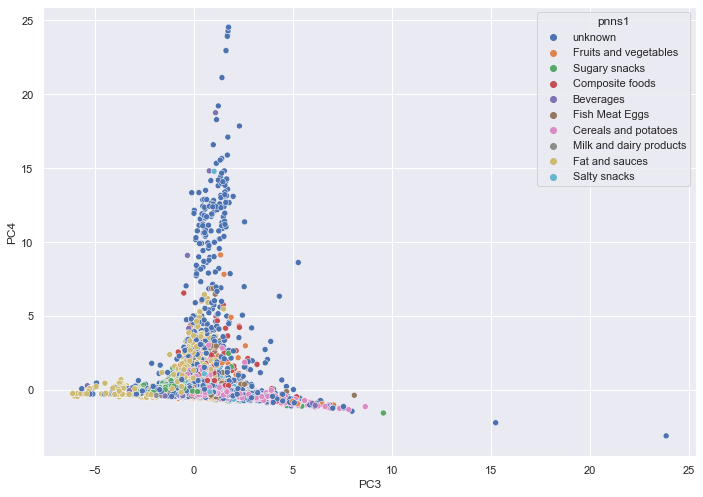

In [405]:
df_sample['PC3']=[ x[2] for x in X_proj]
df_sample['PC4']=[ x[3] for x in X_proj]
df_sample['pnns1']=data['pnns1']
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data=df_sample, x='PC3', y='PC4', hue='pnns1')

# Conclusion:

**Synthèse des faits pertinents pour l’application**

Synthèse des faits pertinents pour l’application
Facteurs négatifs : acides gras saturés, sucres
Facteurs positif :fibres 
Nombre de produits pris en charge : +300'000 produits
L’ACP nous à permis de voir les différents regroupement d’aliments qui peuvent nous permettre de constituer des menues équilibrés 

**Améliorations possibles :**

Imputation du Nutri-Score  grâce à la formule du Nutri-Score et grâce à des algorithmes d'apprentissage automatique
Construire un nutriscore qui peut prendre en compte plusieurs produit choisis 

